<a href="https://colab.research.google.com/github/Rogerio5/Facial-Detection-Project1/blob/main/Facial_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.8 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (98.6 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
Envie as imagens de treino (nome do arquivo deve conter o nome da pessoa, ex: ROGERIO1.jpg)


Saving Rogerio5.jpeg to Rogerio5.jpeg
Saving Rogerio6.jpeg to Rogerio6.jpeg
Saving Rogerio3.jpeg to Rogerio3.jpeg
Saving Rogerio4.jpeg to Rogerio4.jpeg
Saving Rogerio.jpg to Rogerio.jpg

📂 Estrutura do dataset:
dataset
└── ROGERIO
    ├── Rogerio3.jpeg
    ├── Rogerio4.jpeg
    ├── Rogerio5.jpeg
    ├── Rogerio6.jpeg
    └── Rogerio.jpg

1 directory, 5 files
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

Envie imagens para teste:


Saving Rogerio7.jpeg to Rogerio7.jpeg
Saving Rogerio1.jpg to Rogerio1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


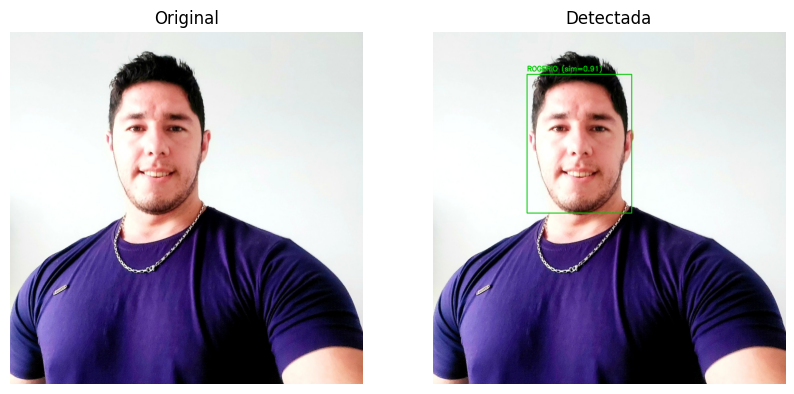

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


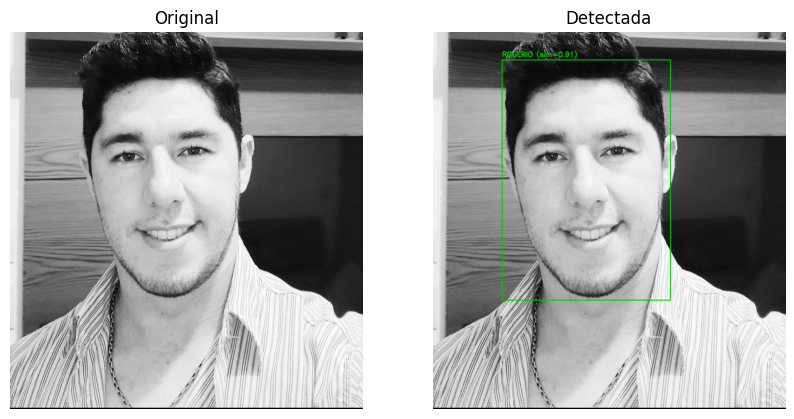


✅ Estrutura completa carregada.
Para iniciar a captura no Colab, execute: loop_reconhecimento_colab()


In [ ]:
# =========================
# PROJETO FINAL - RECONHECIMENTO FACIAL COMPLETO + WEBCAM (COLAB)
# =========================

# 1) Instalar dependências
!pip install -q lz4 mtcnn keras-facenet scikit-learn opencv-python matplotlib \
 tensorflow==2.19.0 tensorflow-text==2.19.0 tensorflow-decision-forests==1.12.0 tf-keras==2.19.0
!apt-get install -q tree

# 2) Imports e configuração
import os, cv2, time, random
import numpy as np
from collections import Counter
from mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import joblib
from google.colab import files, output
from IPython.display import display, Javascript, Image
from base64 import b64decode

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

UNKNOWN_THRESHOLD = 0.60
FACE_SIZE = (160, 160)
MARGIN = 0.20
DATASET_DIR = "dataset"

detector = MTCNN()
embedder = FaceNet()

# 3) Upload de imagens de treino
print("Envie as imagens de treino (nome do arquivo deve conter o nome da pessoa, ex: ROGERIO1.jpg)")
uploaded = files.upload()
os.makedirs(DATASET_DIR, exist_ok=True)

def nome_da_pessoa_do_arquivo(fname):
    base = os.path.basename(fname)
    nome = ''.join([c for c in os.path.splitext(base)[0] if not c.isdigit()])
    return nome.strip().upper() if nome.strip() else "DESCONHECIDO_RAW"

for nome_arquivo in uploaded.keys():
    pessoa = nome_da_pessoa_do_arquivo(nome_arquivo)
    pasta_pessoa = os.path.join(DATASET_DIR, pessoa)
    os.makedirs(pasta_pessoa, exist_ok=True)
    destino = os.path.join(pasta_pessoa, os.path.basename(nome_arquivo))
    if os.path.exists(destino):
        base, ext = os.path.splitext(destino)
        i = 1
        while os.path.exists(f"{base}_{i}{ext}"):
            i += 1
        destino = f"{base}_{i}{ext}"
    os.rename(nome_arquivo, destino)

print("\n📂 Estrutura do dataset:")
!tree dataset

# 4) Funções utilitárias e extração
def clamp(v, lo, hi):
    return max(lo, min(hi, v))

def expand_and_clip_box(x, y, w, h, img_w, img_h, margin=MARGIN):
    cx, cy = x + w/2.0, y + h/2.0
    nw, nh = w*(1+margin), h*(1+margin)
    x1 = int(round(cx - nw/2.0)); y1 = int(round(cy - nh/2.0))
    x2 = int(round(cx + nw/2.0)); y2 = int(round(cy + nh/2.0))
    return clamp(x1,0,img_w-1), clamp(y1,0,img_h-1), clamp(x2,0,img_w-1), clamp(y2,0,img_h-1)

def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def cosine_similarity(a,b):
    return float(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))

def extrair_embeddings(path_dataset):
    X, y = [], []
    for pessoa in sorted(os.listdir(path_dataset)):
        caminho_pessoa = os.path.join(path_dataset, pessoa)
        if not os.path.isdir(caminho_pessoa):
            continue
        for img_nome in os.listdir(caminho_pessoa):
            img_path = os.path.join(caminho_pessoa, img_nome)
            img = cv2.imread(img_path)
            if img is None:
                continue
            H, W = img.shape[:2]
            resultados = detector.detect_faces(img)
            if not resultados:
                continue
            r = max(resultados, key=lambda d: d['box'][2]*d['box'][3])
            x, y_, w, h = r['box']
            x1, y1, x2, y2 = expand_and_clip_box(x, y_, w, h, W, H)
            if x2 <= x1 or y2 <= y1:
                continue
            face = cv2.resize(img[y1:y2, x1:x2], FACE_SIZE)
            emb = embedder.embeddings([bgr_to_rgb(face)])[0]
            X.append(emb); y.append(pessoa)
    return np.array(X), np.array(y)

X, y = extrair_embeddings(DATASET_DIR)
if len(X) == 0:
    raise RuntimeError("Nenhuma face válida encontrada.")

# 5) Treino
classes = sorted(list(set(y)))
MODO = None
if len(classes) >= 2:
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    model = SVC(kernel='linear', probability=True, random_state=SEED)
    model.fit(X, y_encoded)
    joblib.dump((model, encoder), "face_recognition_svm.pkl")
    MODO = "svm"
else:
    pessoa_unica = classes[0]
    embedding_medio = np.mean(X, axis=0)
    joblib.dump((pessoa_unica, embedding_medio), "face_verificacao.pkl")
    MODO = "verificacao"

# 6) Função de reconhecimento com exibição lado a lado
def reconhecer_e_exibir(imagem_path, threshold=UNKNOWN_THRESHOLD, salvar=True, pasta_saida="resultados"):
    os.makedirs(pasta_saida, exist_ok=True)
    orig_bgr = cv2.imread(imagem_path)
    if orig_bgr is None:
        return
    H, W = orig_bgr.shape[:2]
    anotada_bgr = orig_bgr.copy()

    resultados = detector.detect_faces(orig_bgr)
    for r in resultados:
        x, y0, w, h = r['box']
        x1, y1, x2, y2 = expand_and_clip_box(x, y0, w, h, W, H)
        face = cv2.resize(orig_bgr[y1:y2, x1:x2], FACE_SIZE)
        emb = embedder.embeddings([bgr_to_rgb(face)])[0]

        if MODO == "svm":
            probas = model.predict_proba([emb])[0]
            idx = int(np.argmax(probas)); conf = float(probas[idx])
            nome = encoder.classes_[idx] if conf >= threshold else "DESCONHECIDO"
            label = f"{nome} ({conf*100:.1f}%)"
        else:
            pessoa_unica, emb_ref = joblib.load("face_verificacao.pkl")
            sim = cosine_similarity(emb, emb_ref)
            nome = pessoa_unica if sim >= threshold else "DESCONHECIDO"
            label = f"{nome} (sim={sim:.2f})"

        cv2.rectangle(anotada_bgr, (x1, y1), (x2, y2), (0,200,0), 2)
        cv2.putText(anotada_bgr, label, (x1, max(0, y1-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,200,0), 2)

    # Mostrar lado a lado
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    anotada_rgb = cv2.cvtColor(anotada_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(orig_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(anotada_rgb)
    plt.title("Detectada")
    plt.axis("off")
    plt.show()

    if salvar:
        cv2.imwrite(os.path.join(pasta_saida, f"det_{os.path.basename(imagem_path)}"), anotada_bgr)

# 7) Teste com imagens enviadas
print("\nEnvie imagens para teste:")
uploaded_test = files.upload()
for test_img in uploaded_test.keys():
    reconhecer_e_exibir(test_img, threshold=UNKNOWN_THRESHOLD, salvar=True)

# 8) Webcam adaptada para Colab
def take_photo(filename='photo.jpg', quality=0.9):
    js = Javascript(f'''
        async function takePhoto(quality) {{
            const div = document.createElement('div');
            const btn = document.createElement('button');
            btn.textContent = '📸 Capturar';
            btn.style.fontSize = '18px';
            div.appendChild(btn);
            const video = document.createElement('video');
            video.style.display = 'block';
            document.body.appendChild(div);
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({{video: true}});
            video.srcObject             = stream;
            await video.play();
            await new Promise((resolve) => btn.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            google.colab.kernel.invokeFunction('notebook.SavePhoto', [dataUrl, "{filename}"], {{}});
        }}
        takePhoto({quality});
    ''')
    display(js)

def _save_photo(dataUrl, filename):
    header, encoded = dataUrl.split(',', 1)
    data = b64decode(encoded)
    with open(filename, 'wb') as f:
        f.write(data)

# registra callback para salvar a foto
output.register_callback('notebook.SavePhoto', _save_photo)

# 9) Funções para capturar e reconhecer no Colab
def reconhecer_da_webcam(threshold=UNKNOWN_THRESHOLD, salvar=True, pasta_saida="resultados"):
    take_photo()
    time.sleep(2)  # espera a foto ser salva
    if os.path.exists('photo.jpg'):
        reconhecer_e_exibir('photo.jpg', threshold=threshold, salvar=salvar, pasta_saida=pasta_saida)
    else:
        print("❌ Nenhuma foto capturada.")

def loop_reconhecimento_colab(threshold=UNKNOWN_THRESHOLD, salvar=True, pasta_saida="resultados"):
    continuar = True
    foto_num = 1
    while continuar:
        print(f"\n📷 Foto {foto_num} — clique no botão para capturar")
        reconhecer_da_webcam(threshold=threshold, salvar=salvar, pasta_saida=pasta_saida)
        resp = input("Quer capturar outra foto? (s/n): ").strip().lower()
        if resp != 's':
            continuar = False
        foto_num += 1

print("\n✅ Estrutura completa carregada.")
print("Para iniciar a captura no Colab, execute: loop_reconhecimento_colab()")


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


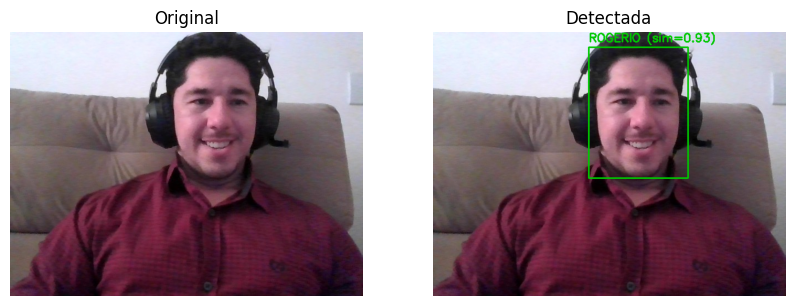

In [ ]:
reconhecer_da_webcam()
